# Facial Expressions Detection

## Video Classification and Object Detection with PyTorch and Open CV

## Background

## Dataset

The dataset used was from the Kaggle facial expression recognition competition, which can be found [here](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data). It contains over 35,000 images, with each one classied with one of the following 7 emotions: (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

In [15]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import pandas as pd

import cv2

## Importing the Data

In [2]:
# from fastai import *

In [3]:
path = 'data/FER/'

In [4]:
# path = Path('data/FER')

In [5]:
# listing the folder directory
# path.ls()

We can use the pandas library to create a dataframe so we can see how our dataset is labeled.

In [2]:
dataframe = pd.read_csv('data/FER/fer2013.csv')
dataframe.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


- The first column is emotion.  Each emotion is assigned a numerical value. 
(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
- The second column contains the pixels for each image.  Each image is of size 48x48 for 2,304 numerical values or pixels. Each numerical value ranges from 0 to 255.
- The third column contains the usage, which tells us if each image is going to be used for for training or testing. We will ignore this column and create our own training and validation set.

In [3]:
# Counting the number of images
print("The dataset has", dataframe.pixels.count(), 'images.')

The dataset has 35887 images.


In [4]:
# Number of pixels for the first image in the set
pixels_list= dataframe.pixels[0].split(' ')
len(pixels_list)

2304

The images are size 48x48 or 2,304 pixels

In [5]:
# Variables inside the "Usage" column.
dataframe.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

## Visualizing the Data

It's pretty easy to visualize an image using the matplotlib library.  Then, we first take the image from above and turn it into an array.  We convert its pixel values into floats.  And finally, we plot the image using plt.imshow().

In [6]:
pixels_list = np.array(pixels_list)

In [7]:
pixels_list = pixels_list.astype('float32')

Emotion: 0


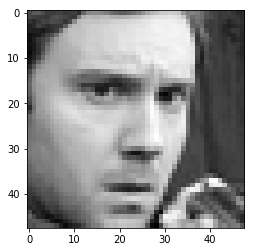

In [8]:
print("Emotion:", dataframe.emotion[0])
plt.imshow(pixels_list.reshape((48,48)), cmap="gray");

In the picture above the emotion is 0 or Angry.

### Preparing The Data

In [9]:
dataframe.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [10]:
images = [i.split(' ') for i in dataframe.pixels]

In [11]:
images_array = np.array(images)

In [12]:
images_array=images_array.reshape(-1,48,48)

In [13]:
images_array.shape

(35887, 48, 48)

Now the images_array is a numpy array of 35,887 images by 2,304 (48x48) pixels each.

We do a similar procedure for the labels.

In [14]:
# The .values method converts a dataframe column into a numpy array
labels = dataframe.emotion.values

In [15]:
labels.shape

(35887,)

In [16]:
labels.dtype, images_array.dtype

(dtype('int64'), dtype('<U3'))

In [17]:
# Converting our arrays into floats
images_array = images_array.astype('float32')
labels = labels.astype('float32')

### Turning the Data into PyTorch Tensors

In order to feed the data into our model. They have to be converted into tensors first. The data will be called xvalues and yvalues for the images and labels, respectively.

In [19]:
# Converting a gray_scale image (1 channel) into RGB (3 channels)
images_RGB = [np.stack((image, image, image), axis=0) for image in images_array] 

In [20]:
images_RGB = np.array(images_RGB)

In [21]:
images_RGB[0].shape

(3, 48, 48)

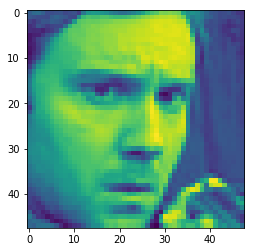

In [22]:
plt.imshow(images_RGB[0][0])

In [23]:
xvalues, yvalues = map(torch.tensor, (images_RGB, labels))

Now we set the validation set to be 20% each of the total set. Then we set the training set to be 80% of the data.

In [24]:
len(xvalues), len(xvalues)*.8

(35887, 28709.600000000002)

In [25]:
# xtest = xvalues[32298:-1]
# ytest = yvalues[32298:-1]
# len(xtest)

In [27]:
35887-28709

7178

In [31]:
xvalid = xvalues[28709:35887]
yvalid = yvalues[28709:35887]
len(xvalid)

7178

In [32]:
xtrain = xvalues[0:28710]
ytrain = yvalues[0:28710]
len(xtrain)

28710

In [33]:
xtrain.shape, ytrain.shape, xvalid.shape, yvalid.shape

(torch.Size([28710, 3, 48, 48]),
 torch.Size([28710]),
 torch.Size([7178, 3, 48, 48]),
 torch.Size([7178]))

### Importing PyTorch And Other Libraries

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

Now the Datasets

### Data Augmentation

Data augmentation is technique used to increase the amount of training data by using information only in our training dataset. It can be used as a way we to reduce overfitting on models. Instead of feeding the model with the same pictures every time, we do small random transformations that don't change what's inside the image (for the human eye) but change its pixel values. Models trained with data augmentation will then generalize better.

We will flip the images horizontally, vertically, add a little bit of brightness, zoom and lighting. For more information on data augmentation with PyTorch, refer to [this link](https://pytorch.org/docs/stable/torchvision/transforms.html).

In [35]:
input_size = 224
batch_size = 64

In [36]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transforms = transforms.Compose([
        transforms.ToPILImage(), # The tensor does not change shape
        transforms.Resize(input_size),
        #transforms.RandomResizedCrop(size=input_size, scale=(1.0, 1.0), ratio=(1.0, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ])

valid_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [37]:
xtrain.shape

torch.Size([28710, 3, 48, 48])

In [38]:
# Initialize xtrain and ytrain as torch tensors
xtrain_tran = torch.empty(size=(len(xtrain), 3, input_size, input_size))
xvalid_tran = torch.empty(size=(len(xvalid), 3, input_size, input_size))

In [39]:
xvalid_tran.size()

torch.Size([7178, 3, 224, 224])

In [40]:
# Add each image, 1 x 1 to the initialized torch tensor
for i in range(len(xtrain)):
    xtrain_tran[i] = train_transforms(xtrain[i])

In [42]:
# Turn list of tensors into one tensor
# xtrain_stacked = torch.stack(xtrain_tran)

In [43]:
for i in range(len(xvalid)):
    xvalid_tran[i] = valid_transforms(xvalid[i])

In [44]:
xtrain_tran.shape, xvalid_tran.shape

(torch.Size([28710, 3, 224, 224]), torch.Size([7178, 3, 224, 224]))

In [45]:
from torch.utils.data import TensorDataset, DataLoader

In [46]:
# We create 3 Pytorch datasets
train_ds = TensorDataset(xtrain_tran, ytrain)
valid_ds = TensorDataset(xvalid_tran, yvalid)
# test_ds = TensorDataset(xtest, ytest)

And the PyTorch Dataloaders

In [47]:
train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
# test_dl = DataLoader(test_ds, batch_size=batch_size)

In [48]:
dataloaders_dict = {'train': train_dl, 'val': valid_dl}

In [49]:
# Let's test our train dataloader
x, y = next(iter(train_dl)) # Here we are getting the x and the y from the dataloader with batch size = 64
# We are grabbing the next item of the iterator
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

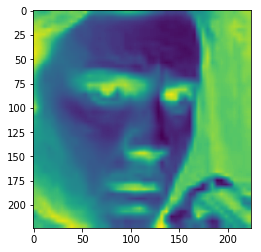

In [50]:
# Image after applying the transforms
plt.imshow(x[0][0]);

## Training The Model

### Training the model

In [51]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()
    
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Everything below happens during each epoch
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)
        
        # Training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluation mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over the data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device, dtype=torch.int64)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                # history is track only if we're training
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # In train mode we calculate the loss by summing the final output and the auxiliary output
                    # but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                
                    # Backward pass + optimize during training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss/ len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        
            print('{} loss: {:.4f} Accuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc: 
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
    
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [52]:
len(dataloaders_dict['train'].dataset), len(dataloaders_dict['val'].dataset)

(28710, 7178)

This helper function sets the .requires_grad attribute of the parameters in the model to False when we are feature extracting. By default, when we load a pretrained model all of the parameters have .requires_grad=True, which is fine if we are training from scratch or finetuning. However, if we are feature extracting and only want to compute gradients for the newly initialized layer then we want all of the other parameters to not require gradients

In [53]:
# Set params.requires_grad = False if we are feature extracting.
# We set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

### Model architecture

To train this model we will use a technique called transfer learning where we will use a model trained on a very large dataset and then adapt it to our own dataset. Here we will use a pre-trained convolutional network model with ResNet 34 architecture. It comes pretrained from ImageNet so its weights have already been computed for us. It has already learned to recognize many features on all of its images, so we can benefit from this knowledge, instead of starting with a randomly initiliazed model.

In [68]:
# In this case the model is resnet
def initialize_model(model_architecture, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
    
    model_ft = models.resnet50(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224
    
    return model_ft, input_size

In [69]:
model_architecture = "resnet50"
num_classes = 7
# When False, we finetune the whole model, when True we only update the reshaped layer params
feature_extract = True

In [70]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_architecture, num_classes, feature_extract, use_pretrained=True)
#print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jupyter/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 52.4MB/s]


The final layers (avgpool and fc) are replaced with new layers made specifically for our model.  The final layer fc here has out_features=t, which corresponds to the 7 classes in our model. All the layers before the last 2 remain the same.  Their training information stays the same.

In [71]:
# Set device ot GPU of we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [72]:
# Send the model to the GPU
model_ft = model_ft.to(device)

In [73]:
# Gather the parameters to be optimized/updated in this run. If we are finetuning we will be updating all parameters.
# However, if we are doing feature extract method, we will only update the parameters that we have just initialized
# i.e. the parameters with requires_grad is True.params_to_update = model_ft.parameters()

print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
            
else:
    for name, param in odel_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

Params to learn:
	 fc.weight
	 fc.bias


In [74]:
# The training optimizer
optimizer_ft = optim.Adam(params_to_update, lr=0.003, weight_decay = 0.005)

In [75]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()

In [76]:
num_epochs = 12

In [77]:
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/11
----------
train loss: 1.6708 Accuracy: 0.3563
val loss: 1.5948 Accuracy: 0.3753

Epoch 1/11
----------
train loss: 1.5889 Accuracy: 0.3954
val loss: 1.5764 Accuracy: 0.3884

Epoch 2/11
----------
train loss: 1.5640 Accuracy: 0.4062
val loss: 1.5669 Accuracy: 0.3948

Epoch 3/11
----------
train loss: 1.5484 Accuracy: 0.4143
val loss: 1.5605 Accuracy: 0.3979

Epoch 4/11
----------
train loss: 1.5376 Accuracy: 0.4197
val loss: 1.5560 Accuracy: 0.4009

Epoch 5/11
----------
train loss: 1.5297 Accuracy: 0.4228
val loss: 1.5526 Accuracy: 0.4029

Epoch 6/11
----------
train loss: 1.5239 Accuracy: 0.4247
val loss: 1.5501 Accuracy: 0.4032

Epoch 7/11
----------
train loss: 1.5194 Accuracy: 0.4259
val loss: 1.5482 Accuracy: 0.4039

Epoch 8/11
----------
train loss: 1.5159 Accuracy: 0.4275
val loss: 1.5468 Accuracy: 0.4037

Epoch 9/11
----------
train loss: 1.5132 Accuracy: 0.4289
val loss: 1.5457 Accuracy: 0.4039

Epoch 10/11
----------
train loss: 1.5110 Accuracy: 0.4297
val loss: 1

In [79]:
torch.save(model_ft, 'data/FER/model-feature_extraction.pth')

In [2]:
model_ft = torch.load('data/FER/model-feature_extraction.pth')

## Sending Model to CPU for Inference

In [4]:
device = torch.device('cpu')
model_ft = model_ft.to(device)

In [6]:
torch.save(model_ft, 'data/FER/model-feature_extraction-CPU.pth');

In [89]:
# Unfreezing all the layers
# We set requires_grad == True to unfreeze the parameters so that the gradients are computed in backward().
# def set_parameter_requires_grad(model, feature_extracting):
#     if feature_extracting:
#         for param in model.parameters():
#             param.requires_grad = True

In [90]:
#model_ft, input_size = initialize_model(model_architecture, num_classes, feature_extract, use_pretrained=True)

In [86]:
# # List the parameters that will be trained
# print("Params to learn:")
# if feature_extract:
#     params_to_update = []
#     for name, param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             params_to_update.append(param)
#             print("\t", name)
            
# else:
#     for name, param in odel_ft.named_parameters():
#         if param.requires_grad == True:
#             print("\t", name)

In [87]:
# num_epochs = 5
# model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

# Video Capture

In [16]:
import imutils
import cv2

In [25]:
cascade_file_path = 'C:\ProgramData\Anaconda3\Lib\site-packages\cv2\data\haarcascade_frontalface_default.xml'
emotion_model_path = 'model-feature_extraction-CPU.pth'

In [26]:
# hyper-parameters for bounding boxes shape

# CascadeClassifier: object detection module from the open CV library
face_detection  = cv2.CascadeClassifier(cascade_file_path)
emotion_classifier = torch.load(emotion_model_path)
emotions = ['angry', 'disgusted', 'scared', 'happy', 'sad', 'suprised', 'neutral']

In [29]:
# Close camera
camera.release()
cv2.destroyAllWindows()